In [1]:
import pandas as pd
import numpy as np
from statistics import median
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from google.colab import drive

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
#change path to whereever main dataset is located
df = pd.read_csv("/content/drive/MyDrive/405 EV_Charging/EV_Charging_Hourly_2 (2).csv")

In [61]:
df.head()

,Unique_Identifier,EV_FLAG,read_date,HR01_KWH,HR02_KWH,HR03_KWH,HR04_KWH,HR05_KWH,HR06_KWH,HR07_KWH,HR08_KWH,HR09_KWH,HR10_KWH,HR11_KWH,HR12_KWH,HR13_KWH,HR14_KWH,HR15_KWH,HR16_KWH,HR17_KWH,HR18_KWH,HR19_KWH,HR20_KWH,HR21_KWH,HR22_KWH,HR23_KWH,HR24_KWH
0,fff487bdefc1a2f01d890d59f458ae00,NaN,2020-01-01,0.004,0.004,0.006,0.007,0.004,0.007,0.009,0.009,0.008,0.006,0.006,0.006,0.005,0.004,0.004,0.006,0.004,0.007,0.005,0.007,0.004,0.005,0.004,0.004
1,fff487bdefc1a2f01d890d59f458ae00,NaN,2020-01-02,0.004,0.004,0.004,0.006,0.006,0.005,0.009,0.010,0.007,0.004,0.006,0.004,0.007,0.004,0.005,0.005,0.004,0.007,0.004,0.007,0.005,0.004,0.004,0.005
2,fff487bdefc1a2f01d890d59f458ae00,NaN,2020-01-03,0.004,0.004,0.004,0.004,0.004,0.004,0.007,0.010,0.008,0.004,0.007,0.004,0.004,0.006,0.004,0.007,0.003,0.007,0.005,0.006,0.004,0.004,0.005,0.004
3,fff487bdefc1a2f01d890d59f458ae00,NaN,2020-01-04,0.004,0.004,0.004,0.005,0.004,0.004,0.009,0.004,0.006,0.009,0.009,0.004,0.007,0.004,0.007,0.005,0.006,0.006,0.006,0.007,0.007,0.004,0.005,0.004
4,fff487bdefc1a2f01d890d59f458ae00,NaN,2020-01-05,0.004,0.004,0.007,0.004,0.007,0.004,0.008,0.006,0.005,0.010,0.009,0.004,0.007,0.005,0.012,0.012,0.014,0.012,0.018,0.014,0.017,0.009,0.005,0.005


In [62]:
df.columns

Index(['Unique_Identifier', 'EV_FLAG', 'read_date', 'HR01_KWH', 'HR02_KWH',
       'HR03_KWH', 'HR04_KWH', 'HR05_KWH', 'HR06_KWH', 'HR07_KWH', 'HR08_KWH',
       'HR09_KWH', 'HR10_KWH', 'HR11_KWH', 'HR12_KWH', 'HR13_KWH', 'HR14_KWH',
       'HR15_KWH', 'HR16_KWH', 'HR17_KWH', 'HR18_KWH', 'HR19_KWH', 'HR20_KWH',
       'HR21_KWH', 'HR22_KWH', 'HR23_KWH', 'HR24_KWH'],
      dtype='object')

In [63]:
df.EV_FLAG.unique()

array([nan,  0.,  1.])

In [64]:
train_df = df[~df['EV_FLAG'].isna()]


In [65]:
train_df.EV_FLAG.unique()

array([0., 1.])

In [66]:
len(train_df)

449619

In [67]:
#Remove all days that include a 0 in the energy reading
train_df = train_df[(train_df.iloc[:, 2:] != 0.0).all(axis=1)]

train_df.reset_index(drop=True, inplace=True)

In [68]:
len(train_df)

436670

In [69]:
# This code is stores energy readings in one list per customer
grouped_df = train_df.groupby('Unique_Identifier')

result = []

for name, group in grouped_df:
    energy_readings = []

    # Iterate through each row in the group
    for _, row in group.iterrows():
        # Extract energy values from the row and append to the list
        energy_values = [row[f'HR{i:02d}_KWH'] for i in range(1, 25)]
        energy_readings.extend(energy_values)

    # Append the collected energy readings for the group to the result list
    result.append({'Unique_Identifier': name, 'energy_readings': energy_readings})

# Convert the result list to DataFrame
result_df = pd.DataFrame(result)

result_df.head()



,Unique_Identifier,energy_readings
0,00e58cd611b49eb6017b58aca738b6d8,"[0.175, 0.266, 0.332, 0.233, 0.124, 0.109, 0.1..."
1,0146da74252fce94e6eb2f7200184cb0,"[0.175, 0.158, 0.15, 0.135, 0.127, 0.125, 0.12..."
2,023dba8ecd27f896f16f74db51ae057d,"[1.315, 0.547, 0.54, 0.636, 0.614, 0.555, 0.63..."
3,02b9c38682fcff2582fc11be3ea4598a,"[0.847, 0.778, 0.765, 0.831, 0.737, 0.75, 0.74..."
4,0561e10867b7847726060382b42e55c2,"[0.11, 0.111, 0.11, 0.106, 0.099, 0.109, 0.109..."


In [70]:

# Remove all Nan values from energy readings
result_df['energy_readings'] = result_df['energy_readings'].apply(lambda x: [value for value in x if not pd.isna(value)])


In [71]:
# Create a mapping of Unique_Identifier to EV_FLAG from new_df
ev_flag_mapping = train_df.set_index('Unique_Identifier')['EV_FLAG'].to_dict()

# Add EV_FLAG column to result_df using the mapping
result_df['EV_FLAG'] = result_df['Unique_Identifier'].map(ev_flag_mapping)

result_df.head()

,Unique_Identifier,energy_readings,EV_FLAG
0,00e58cd611b49eb6017b58aca738b6d8,"[0.175, 0.266, 0.332, 0.233, 0.124, 0.109, 0.1...",0.0
1,0146da74252fce94e6eb2f7200184cb0,"[0.175, 0.158, 0.15, 0.135, 0.127, 0.125, 0.12...",0.0
2,023dba8ecd27f896f16f74db51ae057d,"[1.315, 0.547, 0.54, 0.636, 0.614, 0.555, 0.63...",0.0
3,02b9c38682fcff2582fc11be3ea4598a,"[0.847, 0.778, 0.765, 0.831, 0.737, 0.75, 0.74...",1.0
4,0561e10867b7847726060382b42e55c2,"[0.11, 0.111, 0.11, 0.106, 0.099, 0.109, 0.109...",0.0


In [72]:
def calculate_mean(df, energy_readings_column):
    means = []
    for row in df[energy_readings_column]:

        row_mean = np.mean(row)

        means.append(row_mean)

    df['mean'] = means



calculate_mean(result_df, 'energy_readings')

result_df.head()


,Unique_Identifier,energy_readings,EV_FLAG,mean
0,00e58cd611b49eb6017b58aca738b6d8,"[0.175, 0.266, 0.332, 0.233, 0.124, 0.109, 0.1...",0.0,0.572148
1,0146da74252fce94e6eb2f7200184cb0,"[0.175, 0.158, 0.15, 0.135, 0.127, 0.125, 0.12...",0.0,0.344186
2,023dba8ecd27f896f16f74db51ae057d,"[1.315, 0.547, 0.54, 0.636, 0.614, 0.555, 0.63...",0.0,1.444998
3,02b9c38682fcff2582fc11be3ea4598a,"[0.847, 0.778, 0.765, 0.831, 0.737, 0.75, 0.74...",1.0,1.976221
4,0561e10867b7847726060382b42e55c2,"[0.11, 0.111, 0.11, 0.106, 0.099, 0.109, 0.109...",0.0,0.361359


In [73]:
def calculate_spikes(row):
    spikes_count = 0
    for i in range(1, len(row['energy_readings']) - 1):
        prev_value = row['energy_readings'][i - 1]
        current_value = row['energy_readings'][i]
        buffer = 4

        # Check if current value and its neighbors are 4 kW above the mean
        if (current_value > row['mean'] + buffer) and (prev_value > row['mean'] + buffer):
            spikes_count += 1

    return spikes_count

result_df['number_of_spikes'] = result_df.apply(calculate_spikes, axis = 1)

result_df.head()




,Unique_Identifier,energy_readings,EV_FLAG,mean,number_of_spikes
0,00e58cd611b49eb6017b58aca738b6d8,"[0.175, 0.266, 0.332, 0.233, 0.124, 0.109, 0.1...",0.0,0.572148,1
1,0146da74252fce94e6eb2f7200184cb0,"[0.175, 0.158, 0.15, 0.135, 0.127, 0.125, 0.12...",0.0,0.344186,122
2,023dba8ecd27f896f16f74db51ae057d,"[1.315, 0.547, 0.54, 0.636, 0.614, 0.555, 0.63...",0.0,1.444998,68
3,02b9c38682fcff2582fc11be3ea4598a,"[0.847, 0.778, 0.765, 0.831, 0.737, 0.75, 0.74...",1.0,1.976221,13
4,0561e10867b7847726060382b42e55c2,"[0.11, 0.111, 0.11, 0.106, 0.099, 0.109, 0.109...",0.0,0.361359,0


In [74]:
result_df['number_of_readings'] = result_df['energy_readings'].apply(len)


In [75]:
result_df['spike_percentage'] = (result_df['number_of_spikes'] / result_df['number_of_readings']) * 100

In [76]:
len(result_df)

453

In [77]:
result_df.head()

,Unique_Identifier,energy_readings,EV_FLAG,mean,number_of_spikes,number_of_readings,spike_percentage
0,00e58cd611b49eb6017b58aca738b6d8,"[0.175, 0.266, 0.332, 0.233, 0.124, 0.109, 0.1...",0.0,0.572148,1,25989,0.003848
1,0146da74252fce94e6eb2f7200184cb0,"[0.175, 0.158, 0.15, 0.135, 0.127, 0.125, 0.12...",0.0,0.344186,122,26109,0.467272
2,023dba8ecd27f896f16f74db51ae057d,"[1.315, 0.547, 0.54, 0.636, 0.614, 0.555, 0.63...",0.0,1.444998,68,25610,0.265521
3,02b9c38682fcff2582fc11be3ea4598a,"[0.847, 0.778, 0.765, 0.831, 0.737, 0.75, 0.74...",1.0,1.976221,13,3547,0.366507
4,0561e10867b7847726060382b42e55c2,"[0.11, 0.111, 0.11, 0.106, 0.099, 0.109, 0.109...",0.0,0.361359,0,26013,0.000000


In [78]:
columns_to_keep = ['Unique_Identifier', 'mean', 'spike_percentage', 'EV_FLAG']

# Create a new DataFrame with only the specified columns
result_df = result_df[columns_to_keep]

In [79]:
average_spikes = result_df.groupby('EV_FLAG')['spike_percentage'].mean()


In [80]:
average_spikes

EV_FLAG
0.0    0.173413
1.0    2.588803
Name: spike_percentage, dtype: float64

<ipython-input-81-7d40835c8852>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='EV_FLAG', y='spike_percentage', data=result_df, palette='Set2')


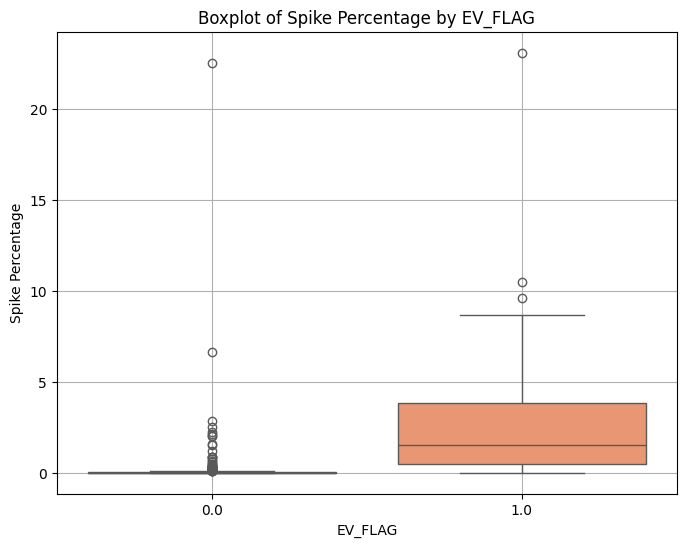

In [81]:


plt.figure(figsize=(8, 6))
sns.boxplot(x='EV_FLAG', y='spike_percentage', data=result_df, palette='Set2')

plt.xlabel('EV_FLAG')
plt.ylabel('Spike Percentage')
plt.title('Boxplot of Spike Percentage by EV_FLAG')

plt.grid(True)
plt.show()



In [82]:


final_df = result_df

In [83]:
final_df.columns

Index(['Unique_Identifier', 'mean', 'spike_percentage', 'EV_FLAG'], dtype='object')

In [84]:
final_df.set_index('Unique_Identifier', inplace=True)


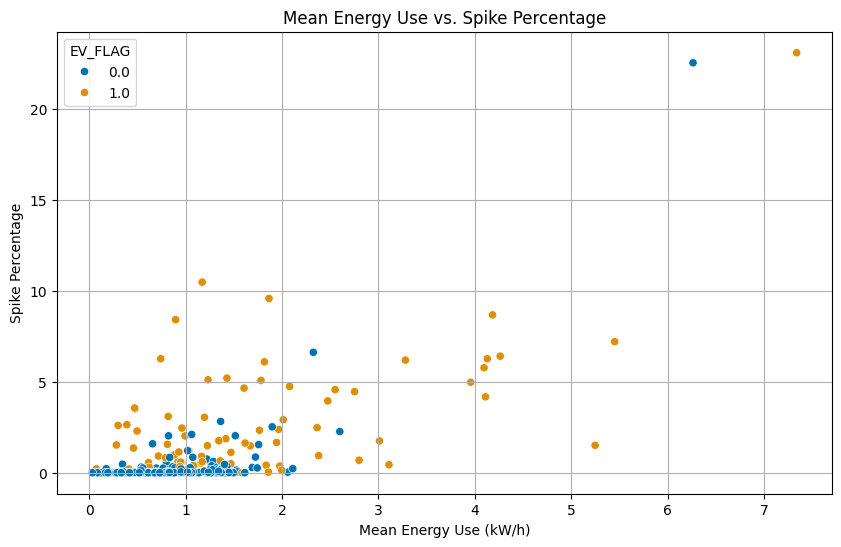

In [85]:



color_palette = 'colorblind'

plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean', y='spike_percentage', hue='EV_FLAG', data=final_df, palette=color_palette)

plt.xlabel('Mean Energy Use (kW/h)')
plt.ylabel('Spike Percentage')
plt.title('Mean Energy Use vs. Spike Percentage')

plt.grid(True)
plt.legend(title='EV_FLAG')
plt.show()


In [86]:
#Model


# Define the feature matrix X and the target vector y
X = final_df.drop(['EV_FLAG'], axis=1)
y = final_df['EV_FLAG']

# Initialize an empty list to store predictions
loocv_predictions = []

# Initialize Leave-One-Out Cross-Validator
loocv = LeaveOneOut()

# Iterate over each data point in the dataset
for train_index, test_index in loocv.split(X):
    # Get the training and test data for this iteration
    X_train_loocv, X_test_loocv = X.iloc[train_index], X.iloc[test_index]
    y_train_loocv, y_test_loocv = y.iloc[train_index], y.iloc[test_index]

    # Create the k-Nearest Neighbors classifier
    k = 5  # Specify the number of neighbors (you can adjust this parameter)
    knn_classifier_loocv = KNeighborsClassifier(n_neighbors=k)

    # Train the model
    knn_classifier_loocv.fit(X_train_loocv, y_train_loocv)

    # Make predictions on the test data
    y_pred_loocv = knn_classifier_loocv.predict(X_test_loocv)

    # Store the prediction
    loocv_predictions.append(y_pred_loocv[0])

# Convert the list of predictions to a numpy array
loocv_predictions = np.array(loocv_predictions)

# Calculate accuracy
accuracy_loocv = accuracy_score(y, loocv_predictions)
print("LOOCV Accuracy:", accuracy_loocv)

# Classification report
print("\nLOOCV Classification Report:")
print(classification_report(y, loocv_predictions))


LOOCV Accuracy: 0.8984547461368654

LOOCV Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       367
         1.0       0.73      0.73      0.73        86

    accuracy                           0.90       453
   macro avg       0.83      0.83      0.83       453
weighted avg       0.90      0.90      0.90       453



In [ ]:
#Below this the model will be used to make prediction for unknown customers

In [87]:
#All the transformations made in this notebook were made to the unknown datapoints outside this notebook because of memory issues
predictions_df = pd.read_csv("/content/prepared_for_predictions.csv")

In [89]:
predictions_df.columns

Index(['Unique_Identifier', 'mean', 'spike_percentage'], dtype='object')

In [95]:
predictions_df.dropna(inplace=True)

# Define the feature matrix X_pred for predictions
X_pred = predictions_df[['mean', 'spike_percentage']]

# Initialize an empty list to store predictions
ev_predictions = []

# Use the trained KNN classifier to predict on X_pred
for index, row in X_pred.iterrows():
    # Get the features for prediction
    features = np.array(row).reshape(1, -1)  # Reshape to (1, n_features) for single prediction

    # Use the trained KNN classifier to make a prediction
    ev_prediction = knn_classifier_loocv.predict(features)[0]
    ev_predictions.append(ev_prediction)

# Create a DataFrame containing 'Unique_Identifier' and 'EV_Prediction'
final_df = pd.DataFrame({
    'Unique_Identifier': predictions_df['Unique_Identifier'],
    'EV_Prediction': ev_predictions
})



Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-pac

Final DataFrame with Predictions:


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not 

In [101]:
final_df.EV_Prediction.value_counts()

EV_Prediction
0.0    4276
1.0     989
Name: count, dtype: int64

In [99]:
final_df.to_csv('final_predictions.csv', index=False)  # Save DataFrame to CSV
